In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# Preprocessing

In [11]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # ev. 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [12]:
fashion_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1,))  
])

fashion_mnist_train_loader = DataLoader(
    datasets.FashionMNIST('/files/', train=True, download=True, transform=fashion_mnist_transform),
    batch_size=batch_size_train, shuffle=True
)

fashion_mnist_test_loader = DataLoader(
    datasets.FashionMNIST('/files/', train=False, download=True, transform=fashion_mnist_transform),
    batch_size=batch_size_test, shuffle=True
)

In [13]:
train_loader_pca = copy.copy(fashion_mnist_train_loader)
test_loader_pca = copy.copy(fashion_mnist_test_loader)

train_loader_auto = copy.copy(fashion_mnist_train_loader)
test_loader_auto = copy.copy(fashion_mnist_test_loader)

In [14]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Pca

In [15]:
""""
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.2860) / 0.3204

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)"
"""

'"\ntrain_data = []\ntrain_labels = []\nfor data, labels in train_loader_pca:\n    train_data.append(data.view(data.size(0), -1))  \n    train_labels.append(labels)\ntrain_data = torch.cat(train_data, dim=0)  \ntrain_labels = torch.cat(train_labels, dim=0)\n\ntrain_data_np = train_data.numpy()\n\npca = PCADigitReducer(100)\ntrain_data_reduced = pca.fit_transform(train_data_np)  \n\ntrain_data_reconstructed_np = pca.inverse_transform(train_data_reduced) \ntrain_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)\n\ntrain_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)\n\ntrain_data_reconstructed = (train_data_reconstructed - 0.2860) / 0.3204\n\nbatch_size_train = train_loader_pca.batch_size\ntrain_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)\ntrain_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)"\n'

# Autoencoder

In [16]:
# Autoencoder
#latent_dim = 100  
autoencoder = Autoencoder2()
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.013257061131298542
Epoch [2/5], Loss: 0.013088169507682323
Epoch [3/5], Loss: 0.010324862785637379
Epoch [4/5], Loss: 0.009434436447918415
Epoch [5/5], Loss: 0.008906204253435135


In [17]:
""" 
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)"
"""

' \nautoencoder.eval()\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nlatent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)\nlatent_features = latent_features.detach()\n\nreconstructed_images = autoencoder.decoder(latent_features.to(device))  \nreconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]\n\nreconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  \nreduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)"\n'

# Experiment

In [18]:
alpha = 0.5
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [19]:
trainingset = fashion_mnist_train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 8

In [20]:

partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]

local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]


for round_idx in range(rounds_classic):
    print(f"Round {round_idx + 1}/{rounds_classic}")
    t1=time.time()

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)
        

    global_weights_classic = federated_averaging(local_weights_classic)


    distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)

    distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
    test_losses = []
    test_fashion(global_model_classic_strong,fashion_mnist_test_loader,test_losses)
    t2= time.time()


    test_accuracies_classic = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in fashion_mnist_test_loader:
            data = data.view(data.shape[0], -1)
            output = global_model_classic_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(fashion_mnist_test_loader.dataset)
    test_accuracies_classic.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')


    results["classic"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)
    results["classic"]["NoCluster"]["precision"].append(precision)
    results["classic"]["NoCluster"]["recall"].append(recall)
    results["classic"]["NoCluster"]["f1"].append(f1)
    results["classic"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data

    """
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1=time.time()

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,fashion_mnist_test_loader,test_losses)
        t2= time.time()

        test_accuracies_classic = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in fashion_mnist_test_loader:
                data = data.view(data.shape[0], -1)
                output = global_model_classic_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(fashion_mnist_test_loader.dataset)
        test_accuracies_classic.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        clusteredResults["classic"][num_cluster]["precision"].append(precision)
        clusteredResults["classic"][num_cluster]["recall"].append(recall)
        clusteredResults["classic"][num_cluster]["f1"].append(f1)
        clusteredResults["classic"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 2.309744
Train Epoch: 1 [640/2540 (25%)]	Loss: 2.225904
Train Epoch: 1 [1280/2540 (50%)]	Loss: 2.071108
Train Epoch: 1 [1920/2540 (75%)]	Loss: 1.843876
Train Epoch: 2 [0/2540 (0%)]	Loss: 1.763952
Train Epoch: 2 [640/2540 (25%)]	Loss: 1.864559
Train Epoch: 2 [1280/2540 (50%)]	Loss: 1.769683
Train Epoch: 2 [1920/2540 (75%)]	Loss: 1.659891
Train Epoch: 3 [0/2540 (0%)]	Loss: 1.784902
Train Epoch: 3 [640/2540 (25%)]	Loss: 1.604913
Train Epoch: 3 [1280/2540 (50%)]	Loss: 1.576991
Train Epoch: 3 [1920/2540 (75%)]	Loss: 1.581379
Train Epoch: 4 [0/2540 (0%)]	Loss: 1.412885
Train Epoch: 4 [640/2540 (25%)]	Loss: 1.525915
Train Epoch: 4 [1280/2540 (50%)]	Loss: 1.435136
Train Epoch: 4 [1920/2540 (75%)]	Loss: 1.258109
Train Epoch: 5 [0/2540 (0%)]	Loss: 1.518604
Train Epoch: 5 [640/2540 (25%)]	Loss: 1.483917
Train Epoch: 5 [1280/2540 (50%)]	Loss: 1.397436
Train Epoch: 5 [1920/2540 (75%)]	Loss: 1.054600
Train Epoch: 6 [0/2540 (0%)]	Loss: 1.

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1855, Accuracy: 5882/10000 (59%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 1.098957
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.985727
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.874758
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.943451
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.749395
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.767546
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.943254
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.846260
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.868519
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.712362
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.797130
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.835441
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.740433
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.625784
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.685456
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.667356
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.542468
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.687290
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.680552
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6707, Accuracy: 7482/10000 (75%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.580719
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.730793
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.648307
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.589261
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.519273
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.688787
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.815311
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.555533
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.634435
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.568001
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.667292
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.721026
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.664152
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.400133
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.666378
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.592217
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.474147
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.663310
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.684093
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5692, Accuracy: 7808/10000 (78%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.802459
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.493685
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.428624
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.629272
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.473883
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.589445
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.532694
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.486156
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.646384
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.632300
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.567219
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.521874
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.568305
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.576496
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.487324
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.466057
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.506361
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.534940
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.547880
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5285, Accuracy: 8015/10000 (80%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.596840
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.730823
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.481683
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.497752
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.419401
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.557425
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.534269
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.452791
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.578271
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.393976
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.474844
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.465377
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.490818
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.607735
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.406311
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.692947
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.656632
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.483309
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.499990
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4999, Accuracy: 8172/10000 (82%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.643130
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.349644
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.588475
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.494085
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.422595
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.353317
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.261913
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.598038
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.456587
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.451493
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.527715
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.532115
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.310520
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.585221
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.619900
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.410171
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.557969
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.386309
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.574632
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4906, Accuracy: 8205/10000 (82%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.504163
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.620546
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.369295
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.470040
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.379498
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.461542
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.654535
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.501331
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.569155
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.449430
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.443844
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.502985
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.266261
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.543502
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.480814
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.302679
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.401230
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.532016
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.454094
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4754, Accuracy: 8243/10000 (82%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.706065
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.345594
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.516465
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.376647
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.329664
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.496600
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.635900
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.537275
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.378610
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.488513
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.402885
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.496332
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.530005
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.423990
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.425929
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.453557
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.417145
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.304163
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.328244
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4708, Accuracy: 8270/10000 (83%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.361939
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.508586
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.477215
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.459813
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.399928
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.412740
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.479428
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.502124
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.369134
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.675748
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.369159
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.604010
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.364862
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.397261
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.432075
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.295059
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.565457
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.501015
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.649739
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5709, Accuracy: 7916/10000 (79%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.515917
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.396209
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.787820
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.298934
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.455987
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.407160
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.549647
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.569203
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.414230
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.439962
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.304510
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.514629
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.352512
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.374236
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.383614
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.270865
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.399998
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.487166
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.458626
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5458, Accuracy: 7986/10000 (80%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.546624
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.547017
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.401792
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.254015
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.411011
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.330043
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.494799
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.433057
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.230165
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.338022
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.319968
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.287771
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.364697
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.447269
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.283108
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.396863
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.323620
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.527942
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.348549
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5474, Accuracy: 7985/10000 (80%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.605358
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.203031
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.296312
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.294099
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.362548
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.612514
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.325967
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.328667
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.556902
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.402740
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.404338
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.232525
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.382991
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.438368
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.604052
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.487768
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.328413
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.315528
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.530631
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5870, Accuracy: 7885/10000 (79%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.637162
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.333020
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.415864
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.359922
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.382915
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.289288
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.402456
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.248949
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.318818
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.246443
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.346945
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.474347
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.232495
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.233342
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.486617
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.297117
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.232671
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.350584
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.332547
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5436, Accuracy: 8059/10000 (81%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.533001
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.185129
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.497090
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.407250
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.365931
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.268396
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.436607
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.266149
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.253842
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.396777
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.372958
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.411585
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.337467
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.363296
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.539599
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.327770
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.412279
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.332978
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.309601
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5847, Accuracy: 7944/10000 (79%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.639186
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.247892
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.401600
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.349935
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.335022
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.289903
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.375859
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.380266
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.407333
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.304949
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.249785
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.263741
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.377800
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.326157
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.306725
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.278615
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.285668
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.286599
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.383807
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6005, Accuracy: 7870/10000 (79%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.587955
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.351899
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.464593
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.382239
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.360370
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.354162
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.407590
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.346136
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.574624
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.310194
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.316145
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.322661
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.554799
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.378682
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.256685
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.355112
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.267038
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.277902
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.336206
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5443, Accuracy: 8088/10000 (81%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.558019
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.239249
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.275566
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.446571
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.172423
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.288951
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.304264
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.424530
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.386578
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.328377
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.215284
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.418307
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.416480
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.149991
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.237675
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.348139
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.222333
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.226000
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.304913
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5313, Accuracy: 8131/10000 (81%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.730963
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.369263
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.374567
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.447149
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.493426
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.147467
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.239922
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.290212
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.230287
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.377834
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.423074
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.372695
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.320445
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.377454
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.541986
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.202090
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.194544
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.235844
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.330319
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5107, Accuracy: 8206/10000 (82%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.556162
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.222631
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.206319
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.424502
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.467429
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.288397
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.241181
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.347615
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.355131
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.389368
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.317011
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.125725
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.259575
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.301766
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.201219
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.227252
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.288409
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.281232
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.239779
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5046, Accuracy: 8258/10000 (83%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.615132
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.342250
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.375578
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.206987
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.232910
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.350217
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.215452
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.235764
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.236406
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.195140
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.218573
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.215213
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.253367
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.183733
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.329929
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.243051
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.217786
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.320531
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.299156
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5100, Accuracy: 8242/10000 (82%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.368295
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.298670
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.201227
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.355479
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.397873
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.336792
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.394434
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.279418
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.237588
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.135413
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.112563
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.326247
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.219188
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.347417
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.338847
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.337652
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.204989
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.202264
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.338535
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5128, Accuracy: 8229/10000 (82%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.258052
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.239296
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.279951
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.453722
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.260474
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.333676
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.510576
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.151770
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.296522
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.353852
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.237497
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.174526
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.124697
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.465398
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.339896
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.269632
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.235284
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.251792
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.253152
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5213, Accuracy: 8233/10000 (82%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.351411
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.395886
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.206603
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.185040
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.312009
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.231214
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.198012
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.143871
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.178039
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.306022
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.160672
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.195243
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.198103
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.264975
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.222941
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.300750
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.300130
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.284857
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.172090
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5146, Accuracy: 8232/10000 (82%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.435892
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.140368
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.258793
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.335748
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.297308
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.230850
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.262346
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.367630
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.229744
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.292476
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.185399
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.355648
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.299541
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.319170
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.304754
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.308884
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.302146
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.142816
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.205601
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5456, Accuracy: 8144/10000 (81%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.357918
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.448543
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.384947
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.187455
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.290065
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.253770
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.152808
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.175448
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.211047
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.270807
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.204620
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.286568
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.236380
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.296191
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.187494
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.209137
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.253040
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.198368
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.301297
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4477, Accuracy: 8427/10000 (84%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.457347
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.285871
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.202540
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.307441
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.435436
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.229734
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.202845
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.274624
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.146765
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.288166
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.347153
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.185377
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.247648
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.288780
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.262364
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.189067
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.190823
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.191831
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.254344
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4406, Accuracy: 8454/10000 (85%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.296191
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.414619
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.285005
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.157345
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.240851
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.309516
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.320354
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.292126
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.283476
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.256878
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.212870
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.247474
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.269909
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.225587
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.385549
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.261182
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.227141
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.221713
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.176326
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4420, Accuracy: 8470/10000 (85%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.295347
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.230364
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.208465
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.153212
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.140019
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.241829
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.308602
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.180117
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.327360
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.233525
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.416108
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.313083
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.207555
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.239427
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.203906
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.320741
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.185919
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.407363
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.194943
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4534, Accuracy: 8425/10000 (84%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.554506
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.157150
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.332083
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.279089
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.236972
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.125077
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.178798
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.270872
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.290281
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.180926
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.258070
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.201897
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.186482
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.272652
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.286849
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.165903
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.249870
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.172807
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.383529
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4476, Accuracy: 8424/10000 (84%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.338111
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.203653
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.471176
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.388551
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.212777
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.253671
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.175591
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.185391
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.176233
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.351403
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.163420
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.217860
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.265400
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.186134
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.293784
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.143363
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.188440
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.193017
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.308736
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4703, Accuracy: 8366/10000 (84%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.161018
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.294818
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.315415
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.276599
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.248592
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.321356
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.201625
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.219883
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.247361
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.230611
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.262433
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.148730
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.122841
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.180994
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.230944
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.222421
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.276373
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.200845
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.215942
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4399, Accuracy: 8458/10000 (85%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.361143
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.320744
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.248326
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.242459
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.181002
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.284522
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.163785
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.242560
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.207089
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.293327
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.224810
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.334119
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.263230
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.175410
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.225824
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.205732
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.145468
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.347797
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.113225
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4391, Accuracy: 8469/10000 (85%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.240253
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.231742
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.309551
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.293854
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.201154
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.331721
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.268643
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.143494
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.269330
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.153787
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.336065
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.168409
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.312615
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.150038
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.171862
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.217946
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.237573
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.171282
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.294753
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4171, Accuracy: 8561/10000 (86%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.369225
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.264094
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.228734
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.217930
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.158020
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.274707
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.167858
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.134833
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.250407
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.299143
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.263749
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.140039
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.178458
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.123868
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.163883
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.231534
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.303032
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.142391
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.313767
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4195, Accuracy: 8554/10000 (86%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.464449
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.267325
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.203284
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.267641
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.321842
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.367590
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.093928
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.304837
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.138551
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.140651
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.251223
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.176109
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.295853
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.188611
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.150487
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.248151
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.224582
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.260776
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.283890
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4003, Accuracy: 8627/10000 (86%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.500760
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.277171
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.293138
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.235922
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.202227
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.166119
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.207322
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.294685
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.202915
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.280477
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.197678
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.112831
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.060615
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.227250
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.276383
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.228561
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.190683
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.277960
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.205196
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4032, Accuracy: 8577/10000 (86%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.241428
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.183711
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.261531
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.330716
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.206991
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.157687
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.208168
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.215526
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.182642
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.274676
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.145131
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.170784
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.150356
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.253995
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.233227
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.192795
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.325345
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.153589
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.200207
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4021, Accuracy: 8616/10000 (86%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.380393
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.287740
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.176203
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.240528
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.334544
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.185814
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.291103
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.202117
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.173214
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.159974
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.261765
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.157645
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.198507
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.163312
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.288598
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.139314
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.135704
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.228408
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.206470
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4008, Accuracy: 8622/10000 (86%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.338804
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.229915
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.249901
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.193132
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.332135
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.256430
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.286714
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.218565
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.436820
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.160932
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.274457
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.114120
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.195333
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.161590
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.296993
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.115574
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.217115
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.313627
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.139735
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3995, Accuracy: 8625/10000 (86%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.215959
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.150739
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.222734
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.320141
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.127787
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.204363
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.213873
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.184327
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.175595
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.193622
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.185606
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.418201
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.123215
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.149913
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.303553
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.301117
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.184553
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.162146
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.213357
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4012, Accuracy: 8604/10000 (86%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.293352
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.226048
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.184368
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.251802
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.112566
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.189337
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.148128
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.097817
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.230683
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.150043
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.167098
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.260059
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.206089
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.253241
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.236999
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.171687
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.218629
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.188464
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.189189
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3928, Accuracy: 8640/10000 (86%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.361545
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.245679
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.227352
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.490059
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.162979
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.168730
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.098112
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.212904
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.143669
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.121064
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.210121
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.280318
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.209848
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.136103
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.228624
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.142030
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.150357
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.094743
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.222137
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3873, Accuracy: 8653/10000 (87%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.447224
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.210079
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.279244
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.158077
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.130786
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.203854
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.157945
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.142238
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.287804
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.274779
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.125923
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.214240
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.088341
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.106676
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.163702
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.174578
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.103516
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.302138
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.207212
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3956, Accuracy: 8649/10000 (86%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.245223
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.151659
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.274291
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.215913
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.142476
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.132342
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.229160
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.230648
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.164693
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.127684
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.225494
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.164879
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.119325
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.138013
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.312638
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.186197
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.226253
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.147848
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.119222
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3900, Accuracy: 8653/10000 (87%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.255885
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.124806
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.285319
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.111023
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.182340
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.157259
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.196962
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.232603
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.150918
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.193198
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.155049
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.072812
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.215017
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.156502
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.174076
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.178406
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.125232
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.159170
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.133162
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3900, Accuracy: 8661/10000 (87%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.345339
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.191232
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.153395
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.304650
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.227868
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.113871
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.179639
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.059728
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.168206
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.157617
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.162806
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.394691
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.102650
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.165749
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.101348
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.327861
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.121016
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.191883
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.238091
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3960, Accuracy: 8650/10000 (86%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.277943
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.150673
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.261609
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.188886
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.131456
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.287359
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.114513
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.080700
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.176418
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.246405
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.100325
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.152417
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.120122
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.211446
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.147769
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.108099
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.297211
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.282752
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.127689
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3884, Accuracy: 8692/10000 (87%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.223784
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.232773
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.164975
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.212948
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.231970
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.163072
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.190578
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.258039
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.409151
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.203326
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.160130
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.177313
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.270911
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.121625
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.157112
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.208975
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.127109
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.209407
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.221494
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3854, Accuracy: 8691/10000 (87%)



In [21]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.47076773986816406], 'accuracy': [82.7], 'precision': [0.836414962143923], 'recall': [0.827], 'f1': [0.8271571053429374], 'trainingTime': [196.02866220474243]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.570863525390625, 0.5458071472167969, 0.5474485626220703, 0.5869806762695312, 0.5436388153076172, 0.5847238708496094, 0.600484033203125, 0.5442625671386718], 'accuracy': [79.16, 79.86, 79.85, 78.85, 80.59, 79.44, 78.7, 80.88], 'precision': [0.81850926612831, 0.8245307393935761, 0.8202674768126539, 0.8186902624243585, 0.8221007741267469, 0.8158925599478589, 0.8193560597056244, 0.8212431387312364], 'recall': [0.7916000000000001, 0.7986, 0.7985, 0.7885, 0.8059, 0.7944, 0.787, 0.8088000000000001], 'f1': [0.7909259786036429, 0.7989616984804996, 0.798720477704328, 0.7875515683378504, 0.805176357932719, 0.791323845561716, 0.7875707277131916, 0.8073763669695927], 'trainingTime': [3

## PCA

In [22]:
trainingset_pca = train_loader_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()

In [23]:
partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

pca_client_loaders = []
local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

for client_idx, client_indices in partitioned_data_pca.items():
    client_data = [trainingset_pca[i][0] for i in client_indices]  
    client_labels = [trainingset_pca[i][1] for i in client_indices]  
    
    client_data = torch.stack(client_data, dim=0)
    client_data = client_data.view(client_data.size(0), -1)  
    
    pca = PCADigitReducer(100)
    client_data_reduced = pca.fit_transform(client_data.numpy())  
    
    client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
    client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
    
    client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
    client_data_reconstructed = (client_data_reconstructed - 0.2860) / 0.3204  
    
    client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
    pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))


rounds_pca = 8
for round_idx in range(rounds_pca):
    print(f"Round {round_idx + 1}/{rounds_pca}")
    t1=time.time()

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []


        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        

    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)

    distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
    test_losses = []
    test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    t2= time.time()

    test_accuracies_pca = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_pca:
            data = data.view(data.shape[0], -1)
            output = global_model_pca_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    # Save results for non-clustered classic
    results["pca"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_pca)
    results["pca"]["NoCluster"]["precision"].append(precision)
    results["pca"]["NoCluster"]["recall"].append(recall)
    results["pca"]["NoCluster"]["f1"].append(f1)
    results["pca"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = []

    # Apply PCA after clustering
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  

        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  

        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)  
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.2860) / 0.3204  

        client_dataset_pca_clustered = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca_clustered, batch_size=batch_size_train, shuffle=True))


    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1=time.time()

        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
        t2= time.time()
    
        test_accuracies_pca = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_pca:
                data = data.view(data.shape[0], -1)
                output = global_model_pca_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save results for clustered classic
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_pca)
        clusteredResults["pca"][num_cluster]["precision"].append(precision)
        clusteredResults["pca"][num_cluster]["recall"].append(recall)
        clusteredResults["pca"][num_cluster]["f1"].append(f1)
        clusteredResults["pca"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 2.394043
Train Epoch: 1 [640/2540 (25%)]	Loss: 2.095801
Train Epoch: 1 [1280/2540 (50%)]	Loss: 1.789553
Train Epoch: 1 [1920/2540 (75%)]	Loss: 1.629623
Train Epoch: 2 [0/2540 (0%)]	Loss: 1.423142
Train Epoch: 2 [640/2540 (25%)]	Loss: 1.351688
Train Epoch: 2 [1280/2540 (50%)]	Loss: 1.037646
Train Epoch: 2 [1920/2540 (75%)]	Loss: 1.046656
Train Epoch: 3 [0/2540 (0%)]	Loss: 1.121717
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.805455
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.972083
Train Epoch: 3 [1920/2540 (75%)]	Loss: 1.005781
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.845326
Train Epoch: 4 [640/2540 (25%)]	Loss: 1.003564
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.882453
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.859144
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.654203
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.632978
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.902619
Train Epoch: 5 [1920/2540 (75%)]	Loss: 0.814646
Train Epoch: 6 [0/2540 (0%)]	Loss: 0.

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.6754, Accuracy: 6280/10000 (63%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.675956
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.571724
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.699856
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.607514
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.641351
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.697010
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.402285
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.595989
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.577634
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.472567
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.682600
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.443025
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.663178
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.604455
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.517436
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.401801
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.397305
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.545137
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.483730
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3730, Accuracy: 6986/10000 (70%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.443544
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.474644
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.632199
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.474397
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.458927
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.465358
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.577153
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.421412
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.391022
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.633195
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.375827
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.512116
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.537965
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.580665
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.479684
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.313983
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.400710
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.638889
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.363884
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3242, Accuracy: 7127/10000 (71%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.501333
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.534001
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.377461
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.566005
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.564655
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.430576
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.485964
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.507929
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.634315
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.466366
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.414257
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.343236
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.441207
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.375618
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.561425
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.468924
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.421291
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.346640
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.440588
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2947, Accuracy: 7179/10000 (72%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.482253
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.439791
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.430543
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.611055
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.332920
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.538061
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.291957
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.376355
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.368158
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.403502
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.393159
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.502202
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.354780
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.231459
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.445489
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.447856
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.353965
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.309996
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.272223
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2727, Accuracy: 7245/10000 (72%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.378468
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.484403
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.389969
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.426082
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.336463
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.572447
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.432862
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.375553
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.218873
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.285698
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.475662
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.440782
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.454408
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.362029
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.269055
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.362168
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.480465
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.415066
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.377445
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2513, Accuracy: 7204/10000 (72%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.409227
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.318257
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.429243
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.357638
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.616107
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.250455
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.420035
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.333986
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.385577
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.361545
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.365701
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.310183
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.351051
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.371409
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.408066
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.341761
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.479535
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.248590
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.305065
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2399, Accuracy: 7252/10000 (73%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.350549
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.242216
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.299719
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.403979
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.387210
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.491877
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.237725
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.320654
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.397866
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.370363
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.426619
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.384198
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.298849
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.371457
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.355928
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.380070
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.320468
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.306590
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.280006
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2240, Accuracy: 7243/10000 (72%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.267302
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.338963
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.346878
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.369538
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.351102
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.352255
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.299348
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.384298
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.427680
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.300449
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.298505
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.344580
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.412328
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.274653
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.434526
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.259916
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.231709
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.383042
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.175395
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2543, Accuracy: 6797/10000 (68%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.459420
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.401403
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.402082
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.523484
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.504196
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.227174
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.228852
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.393510
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.282922
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.261379
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.267319
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.284566
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.341722
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.434462
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.228430
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.300932
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.210842
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.293133
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.208937
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2233, Accuracy: 6813/10000 (68%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.345749
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.310866
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.296745
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.297162
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.316402
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.327336
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.158008
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.261012
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.220579
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.353037
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.380433
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.246291
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.255557
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.273722
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.248461
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.380040
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.232948
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.239582
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.197929
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2233, Accuracy: 6753/10000 (68%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.390595
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.368864
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.119430
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.205989
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.311366
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.245160
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.462365
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.208946
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.226467
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.257771
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.279980
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.152511
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.295231
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.394632
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.245686
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.209552
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.262542
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.171893
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.271527
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1958, Accuracy: 6695/10000 (67%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.350922
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.231413
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.321650
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.190167
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.142280
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.337773
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.345309
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.254234
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.401316
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.217640
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.196576
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.107629
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.238411
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.135803
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.249335
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.223193
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.215009
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.290521
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.268564
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1842, Accuracy: 6669/10000 (67%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.450547
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.193788
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.131211
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.442351
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.344931
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.317599
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.242388
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.304649
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.178935
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.188911
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.159139
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.250279
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.282899
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.169168
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.272130
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.321692
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.083511
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.117583
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.216677
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1634, Accuracy: 6710/10000 (67%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.468362
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.094510
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.251971
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.211130
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.203654
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.217528
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.128209
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.194708
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.204334
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.132345
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.168822
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.140820
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.217276
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.195583
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.212043
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.128120
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.215540
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.201490
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.172142
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1657, Accuracy: 6742/10000 (67%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.283014
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.167538
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.340927
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.326370
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.104803
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.232825
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.191270
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.178252
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.164704
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.084887
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.207289
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.119697
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.111581
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.146065
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.137112
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.190223
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.130104
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.173828
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.126156
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1505, Accuracy: 6687/10000 (67%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.348624
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.236665
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.201780
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.110949
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.249302
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.220632
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.213683
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.143258
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.099771
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.275566
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.224906
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.165799
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.097113
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.161660
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.187657
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.096069
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.135248
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.106438
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.166381
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1212, Accuracy: 7024/10000 (70%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.278322
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.189484
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.256371
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.205319
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.124110
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.128444
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.148048
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.093020
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.240842
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.097552
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.150704
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.246640
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.171200
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.103570
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.151877
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.136162
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.257368
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.058028
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.184343
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1003, Accuracy: 7149/10000 (71%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.288761
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.210090
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.127356
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.104718
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.162319
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.129554
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.247576
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.143809
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.085927
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.147281
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.122700
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.099998
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.075442
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.091592
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.206864
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.176986
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.115540
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.097695
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.143182
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0553, Accuracy: 7408/10000 (74%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.149949
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.268849
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.214593
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.156834
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.103928
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.177709
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.108959
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.174031
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.137084
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.216135
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.099700
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.078818
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.121435
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.123691
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.230208
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.120396
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.136514
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.123198
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.075334
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0687, Accuracy: 7187/10000 (72%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.276899
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.191962
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.316499
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.157714
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.177841
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.108861
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.147377
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.412797
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.123960
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.127034
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.129196
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.178842
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.166332
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.096033
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.169106
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.150981
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.054656
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.097638
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.202375
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0519, Accuracy: 7145/10000 (71%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.350253
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.160904
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.178166
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.254470
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.105183
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.156303
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.225988
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.119845
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.051866
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.116198
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.120899
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.164956
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.100517
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.174981
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.079619
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.212808
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.072366
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.104277
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.088738
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0649, Accuracy: 7054/10000 (71%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.186611
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.174412
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.195431
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.107575
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.119356
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.140920
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.156909
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.114038
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.135460
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.188880
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.096191
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.139243
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.138884
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.100094
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.135774
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.130672
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.084695
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.089619
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.061831
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0481, Accuracy: 7126/10000 (71%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.311715
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.087471
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.178560
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.102619
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.068698
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.159070
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.140118
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.136238
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.045277
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.100205
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.129867
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.165221
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.163010
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.071179
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.198281
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.138602
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.154499
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.080684
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.178111
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0482, Accuracy: 7002/10000 (70%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.355659
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.320419
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.089754
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.168684
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.103974
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.230116
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.111013
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.159297
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.064652
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.097842
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.252643
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.178766
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.145274
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.086711
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.055336
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.093847
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.083873
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.100675
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.074416
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0537, Accuracy: 7154/10000 (72%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.208444
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.129798
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.155435
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.233356
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.297260
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.114018
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.122152
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.143933
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.114785
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.078081
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.095460
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.159186
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.155497
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.088335
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.104074
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.208558
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.179802
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.091810
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.176834
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0717, Accuracy: 7162/10000 (72%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.265892
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.093646
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.152432
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.158270
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.154188
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.061172
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.164018
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.195664
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.138496
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.161604
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.092922
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.202121
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.069041
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.122597
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.110973
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.091404
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.066616
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.143735
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.117815
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0527, Accuracy: 7139/10000 (71%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.152425
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.121025
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.285770
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.085791
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.115827
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.103328
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.213191
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.140114
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.105669
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.152935
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.053423
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.123997
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.164629
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.158215
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.129416
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.115030
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.079698
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.127330
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.207493
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0469, Accuracy: 7058/10000 (71%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.238266
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.171281
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.191247
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.096373
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.162830
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.100282
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.071578
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.155407
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.145973
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.109420
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.185716
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.212000
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.125069
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.088103
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.102102
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.057990
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.126169
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.141814
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.071997
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0617, Accuracy: 6972/10000 (70%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.236027
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.234416
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.171211
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.141605
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.094733
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.083654
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.076566
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.073307
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.055183
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.215603
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.076384
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.061426
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.045702
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.064871
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.067666
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.089720
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.080214
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.199473
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.066537
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0338, Accuracy: 7051/10000 (71%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.281465
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.160131
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.113585
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.206555
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.243481
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.134785
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.173410
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.090093
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.064665
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.080314
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.126982
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.053822
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.104376
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.149622
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.035979
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.162053
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.063166
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.044550
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.041595
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0405, Accuracy: 6955/10000 (70%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.224762
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.193587
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.175006
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.135051
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.211025
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.123674
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.108234
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.189443
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.081674
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.130848
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.159747
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.099939
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.158089
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.128833
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.059498
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.175359
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.094034
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.101547
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.076420
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0494, Accuracy: 6877/10000 (69%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.187969
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.160882
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.145139
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.259748
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.113614
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.105020
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.218606
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.217030
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.062117
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.087429
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.146469
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.082403
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.149613
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.067118
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.079938
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.097070
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.136280
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.111629
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.090537
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0536, Accuracy: 6914/10000 (69%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.244427
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.224352
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.129359
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.183203
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.079050
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.113472
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.134917
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.110415
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.143434
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.111281
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.095993
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.116134
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.089466
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.072537
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.163686
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.123504
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.060633
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.112025
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.083347
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0452, Accuracy: 6976/10000 (70%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.240132
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.198359
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.168688
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.255247
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.109192
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.148555
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.118186
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.071127
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.074757
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.055991
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.075219
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.198405
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.089208
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.078585
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.167889
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.080906
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.064618
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.080380
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.052818
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0355, Accuracy: 6944/10000 (69%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.259698
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.201280
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.160065
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.176205
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.107402
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.075518
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.113432
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.104951
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.224264
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.055337
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.126051
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.078580
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.120563
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.119493
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.124343
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.100265
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.071074
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.092301
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.095147
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0269, Accuracy: 6969/10000 (70%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.319656
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.214612
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.147394
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.121628
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.206951
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.159241
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.084665
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.276218
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.046249
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.123954
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.073119
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.079347
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.045349
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.130700
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.100325
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.112024
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.077111
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.055460
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.150567
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0270, Accuracy: 6968/10000 (70%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.144196
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.277162
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.366153
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.171644
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.253021
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.069939
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.188103
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.156953
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.069803
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.052900
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.155721
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.143660
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.100930
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.097064
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.052559
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.101750
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.090769
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.089388
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.114763
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0234, Accuracy: 6954/10000 (70%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.175504
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.135077
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.157056
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.145974
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.077471
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.143854
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.068133
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.186456
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.131932
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.058457
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.083106
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.190332
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.191939
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.037261
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.131628
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.095311
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.071249
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.101941
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.066038
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0145, Accuracy: 6961/10000 (70%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.204856
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.391566
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.323385
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.122592
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.062650
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.135781
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.045781
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.124507
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.164630
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.142184
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.069794
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.084227
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.143059
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.051607
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.045599
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.064969
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.138598
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.087604
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.121820
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9970, Accuracy: 7014/10000 (70%)

Round 1/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.213295
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.238787
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.142829
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.213005
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.776503
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.115217
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.199130
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.106548
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.257054
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.081093
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.111671
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.051505
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.149214
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.091258
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.172539
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.167558
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.055678
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.076875
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.066830
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9870, Accuracy: 7093/10000 (71%)

Round 2/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.193422
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.260702
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.302266
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.216950
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.070282
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.092516
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.031390
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.132429
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.118827
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.162591
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.071850
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.144292
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.163725
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.153419
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.087749
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.112242
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.044323
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.053953
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.105745
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9713, Accuracy: 7145/10000 (71%)

Round 3/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.245431
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.127709
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.149279
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.111155
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.082602
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.157023
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.139942
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.213642
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.186976
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.071115
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.050460
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.091515
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.072462
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.090533
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.107714
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.067967
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.140537
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.039717
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.038344
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9672, Accuracy: 7179/10000 (72%)

Round 4/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.135399
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.183770
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.137616
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.166802
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.139294
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.110658
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.158465
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.119135
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.156302
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.098226
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.170201
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.046001
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.037616
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.070981
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.059194
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.243342
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.086705
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.085869
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.072488
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9766, Accuracy: 7122/10000 (71%)

Round 5/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.179154
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.106074
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.169171
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.198206
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.069349
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.077979
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.162229
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.173041
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.113246
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.157864
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.108425
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.148708
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.099623
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.060689
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.048945
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.144042
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.061526
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.065584
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.154439
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9734, Accuracy: 7062/10000 (71%)

Round 6/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.297116
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.258323
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.217299
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.369385
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.206517
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.083858
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.204619
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.156985
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.081348
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.062091
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.144396
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.169689
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.089238
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.066184
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.152673
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.071883
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.062820
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.106395
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.061474
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9536, Accuracy: 7170/10000 (72%)

Round 7/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.230377
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.273898
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.189235
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.256458
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.207118
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.225743
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.187549
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.099736
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.103238
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.102558
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.095673
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.114300
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.071905
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.149848
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.036358
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.119386
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.081478
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.077395
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.089614
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9455, Accuracy: 7172/10000 (72%)

Round 8/8
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 0.262982
Train Epoch: 1 [640/2540 (25%)]	Loss: 0.155766
Train Epoch: 1 [1280/2540 (50%)]	Loss: 0.128703
Train Epoch: 1 [1920/2540 (75%)]	Loss: 0.323883
Train Epoch: 2 [0/2540 (0%)]	Loss: 0.084827
Train Epoch: 2 [640/2540 (25%)]	Loss: 0.189031
Train Epoch: 2 [1280/2540 (50%)]	Loss: 0.166246
Train Epoch: 2 [1920/2540 (75%)]	Loss: 0.076687
Train Epoch: 3 [0/2540 (0%)]	Loss: 0.087835
Train Epoch: 3 [640/2540 (25%)]	Loss: 0.223295
Train Epoch: 3 [1280/2540 (50%)]	Loss: 0.086046
Train Epoch: 3 [1920/2540 (75%)]	Loss: 0.029075
Train Epoch: 4 [0/2540 (0%)]	Loss: 0.053128
Train Epoch: 4 [640/2540 (25%)]	Loss: 0.077536
Train Epoch: 4 [1280/2540 (50%)]	Loss: 0.031501
Train Epoch: 4 [1920/2540 (75%)]	Loss: 0.062971
Train Epoch: 5 [0/2540 (0%)]	Loss: 0.054686
Train Epoch: 5 [640/2540 (25%)]	Loss: 0.052810
Train Epoch: 5 [1280/2540 (50%)]	Loss: 0.055004
Train Epoch: 5 [1920/2540 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9416, Accuracy: 7141/10000 (71%)



In [24]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.47076773986816406], 'accuracy': [82.7], 'precision': [0.836414962143923], 'recall': [0.827], 'f1': [0.8271571053429374], 'trainingTime': [196.02866220474243]}}, 'pca': {'NoCluster': {'losses': [1.2240458374023437], 'accuracy': [72.43], 'precision': [0.7773943980256408], 'recall': [0.7243], 'f1': [0.7176038375522478], 'trainingTime': [27.308010578155518]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.570863525390625, 0.5458071472167969, 0.5474485626220703, 0.5869806762695312, 0.5436388153076172, 0.5847238708496094, 0.600484033203125, 0.5442625671386718], 'accuracy': [79.16, 79.86, 79.85, 78.85, 80.59, 79.44, 78.7, 80.88], 'precision': [0.81850926612831, 0.8245307393935761, 0.8202674768126539, 0.8186902624243585, 0.8221007741267469, 0.8158925599478589, 0.8193560597056244, 0.8212431387312364], 'recall': [0.7916000000000001, 0.7986, 0.7985, 0.7885, 0.8059, 0.7944, 0.787, 0.808800000000000

In [ ]:
results =  {'classic': {'NoCluster': {'losses': [0.47076773986816406], 'accuracy': [82.7], 'precision': [0.836414962143923], 'recall': [0.827], 'f1': [0.8271571053429374], 'trainingTime': [196.02866220474243]}}, 'pca': {'NoCluster': {'losses': [1.2240458374023437], 'accuracy': [72.43], 'precision': [0.7773943980256408], 'recall': [0.7243], 'f1': [0.7176038375522478], 'trainingTime': [27.308010578155518]}}, 'autoencoder': {}}
clusteredResults=  {'classic': {2: {'losses': [0.570863525390625, 0.5458071472167969, 0.5474485626220703, 0.5869806762695312, 0.5436388153076172, 0.5847238708496094, 0.600484033203125, 0.5442625671386718], 'accuracy': [79.16, 79.86, 79.85, 78.85, 80.59, 79.44, 78.7, 80.88], 'precision': [0.81850926612831, 0.8245307393935761, 0.8202674768126539, 0.8186902624243585, 0.8221007741267469, 0.8158925599478589, 0.8193560597056244, 0.8212431387312364], 'recall': [0.7916000000000001, 0.7986, 0.7985, 0.7885, 0.8059, 0.7944, 0.787, 0.8088000000000001], 'f1': [0.7909259786036429, 0.7989616984804996, 0.798720477704328, 0.7875515683378504, 0.805176357932719, 0.791323845561716, 0.7875707277131916, 0.8073763669695927], 'trainingTime': [36.16351556777954, 37.77119970321655, 38.56438684463501, 39.103790283203125, 52.15783929824829, 46.37804627418518, 44.37732148170471, 49.06515455245972]}, 4: {'losses': [0.5313447143554687, 0.5106803131103516, 0.5045611053466796, 0.5100116668701172, 0.5127651245117187, 0.5213184997558594, 0.5146487823486328, 0.5455696655273438], 'accuracy': [81.31, 82.06, 82.58, 82.42, 82.29, 82.33, 82.32, 81.44], 'precision': [0.8329242008481247, 0.8343608335063181, 0.8355691375456406, 0.8374642756923798, 0.8370676008425224, 0.8395781029135388, 0.8402070419230885, 0.8417019103767169], 'recall': [0.8131, 0.8206, 0.8257999999999999, 0.8242, 0.8229000000000001, 0.8232999999999999, 0.8231999999999999, 0.8144], 'f1': [0.8131318060561339, 0.8203739040853133, 0.8250355605447792, 0.8233772745435155, 0.8229746540499081, 0.8227654907386113, 0.8231007966422853, 0.8156199259719076], 'trainingTime': [90.54936623573303, 83.21166205406189, 80.7781457901001, 75.58202528953552, 80.50954842567444, 94.85065793991089, 129.68072700500488, 78.82648515701294]}, 6: {'losses': [0.44770301208496094, 0.440632275390625, 0.4419530578613281, 0.4533648498535156, 0.44758374938964846, 0.47028067626953124, 0.43986120910644533, 0.43908120727539063], 'accuracy': [84.27, 84.54, 84.7, 84.25, 84.24, 83.66, 84.58, 84.69], 'precision': [0.8513733603264289, 0.853501724330509, 0.8531427344328346, 0.8575641482089832, 0.8539638037569836, 0.8565404874713411, 0.8557615505782048, 0.857203734435422], 'recall': [0.8427000000000001, 0.8454, 0.8470000000000001, 0.8425, 0.8423999999999999, 0.8366, 0.8458, 0.8469], 'f1': [0.8436835326797143, 0.8464910262723061, 0.846528896934332, 0.8445299837125724, 0.8434720496176304, 0.8390059896577362, 0.8471249468218687, 0.8481551323189767], 'trainingTime': [146.17852210998535, 105.54267811775208, 206.57456707954407, 97.14573431015015, 102.95522332191467, 114.48540663719177, 91.34517574310303, 83.88237738609314]}, 8: {'losses': [0.41705177001953125, 0.41953948364257815, 0.4003392852783203, 0.4031991668701172, 0.40212984619140624, 0.4007817779541016, 0.39950448608398437, 0.40124530639648437], 'accuracy': [85.61, 85.54, 86.27, 85.77, 86.16, 86.22, 86.25, 86.04], 'precision': [0.859312704667088, 0.8586971062093237, 0.8639436551041946, 0.8620383601203138, 0.8641895501060682, 0.8646160807180815, 0.8639834685349268, 0.8638735537543903], 'recall': [0.8561, 0.8554, 0.8627, 0.8576999999999998, 0.8615999999999999, 0.8622, 0.8625, 0.8604], 'f1': [0.8559263206591078, 0.854259376777188, 0.8629461839476742, 0.8586987834355098, 0.861955155689295, 0.8624880126611801, 0.8618295467989368, 0.8607092033393808], 'trainingTime': [144.37776517868042, 143.48128175735474, 150.84226751327515, 154.77480006217957, 143.5453326702118, 163.7980134487152, 167.1835560798645, 160.58328866958618]}, 10: {'losses': [0.3928482208251953, 0.3872859405517578, 0.3955651153564453, 0.3900254913330078, 0.3900293670654297, 0.3959846649169922, 0.3883984436035156, 0.3853960815429687], 'accuracy': [86.4, 86.53, 86.49, 86.53, 86.61, 86.5, 86.92, 86.91], 'precision': [0.8669098073070375, 0.8661096898019849, 0.8676262043304895, 0.8685362150359703, 0.8689581854819277, 0.870024109694074, 0.8720244194474075, 0.870688445795887], 'recall': [0.8639999999999999, 0.8653000000000001, 0.8649000000000001, 0.8653000000000001, 0.8661, 0.865, 0.8692, 0.8691000000000001], 'f1': [0.863871886659448, 0.864427482881384, 0.8634101475010757, 0.8646178458492928, 0.8652954335976523, 0.8642007653610426, 0.8687833401939095, 0.8679469006194429], 'trainingTime': [223.90191650390625, 187.07878756523132, 188.67047142982483, 185.90910840034485, 180.66124033927917, 183.08939957618713, 218.72792744636536, 196.33026599884033]}}, 'pca': {2: {'losses': [1.25430810546875, 1.2233267822265625, 1.2232924438476562, 1.1957776733398437, 1.18417353515625, 1.163424169921875, 1.16574052734375, 1.1504889892578125], 'accuracy': [67.97, 68.13, 67.53, 66.95, 66.69, 67.1, 67.42, 66.87], 'precision': [0.7574812086163007, 0.7589704188035655, 0.7570623158074146, 0.7525661576184011, 0.7493652759961107, 0.7432517026122929, 0.7377092477556585, 0.7388777240191499], 'recall': [0.6797000000000001, 0.6813, 0.6753, 0.6695, 0.6668999999999999, 0.671, 0.6742, 0.6687], 'f1': [0.659883048006208, 0.664933703042363, 0.6517487682412297, 0.6504069448986053, 0.6436767406557892, 0.6504745944876457, 0.6542139125237145, 0.6493211691830016], 'trainingTime': [7.45749568939209, 6.875573635101318, 6.938857555389404, 6.869043588638306, 6.813024997711182, 6.817445278167725, 6.867502450942993, 7.171543836593628]}, 4: {'losses': [1.1212023193359375, 1.1003410888671874, 1.0553109985351563, 1.068736474609375, 1.0518560546875, 1.0648694213867187, 1.048103790283203, 1.0481757385253907], 'accuracy': [70.24, 71.49, 74.08, 71.87, 71.45, 70.54, 71.26, 70.02], 'precision': [0.7543887284660151, 0.756045567695791, 0.7760252841530849, 0.7627610293351023, 0.7572777154466308, 0.7497980948657503, 0.747378764447015, 0.7440675251676296], 'recall': [0.7024, 0.7149000000000001, 0.7407999999999999, 0.7186999999999999, 0.7144999999999999, 0.7053999999999999, 0.7126, 0.7001999999999999], 'f1': [0.6928523581755447, 0.7067430776925535, 0.7383952075890867, 0.714309804578173, 0.7090007400365347, 0.7011695957701213, 0.7064276082182379, 0.6982597573071792], 'trainingTime': [12.344215869903564, 12.144582033157349, 11.781381130218506, 11.982959270477295, 11.840586185455322, 11.608509302139282, 11.675881385803223, 11.92897343635559]}, 6: {'losses': [1.0536745483398438, 1.0717382202148438, 1.0527154541015624, 1.0468765075683595, 1.0617424438476561, 1.0338246398925781, 1.0405402709960938, 1.0493605590820312], 'accuracy': [71.54, 71.62, 71.39, 70.58, 69.72, 70.51, 69.55, 68.77], 'precision': [0.7559363708205173, 0.7478631887841717, 0.7473029281595002, 0.7373674787356381, 0.7359563757289411, 0.7388163290675345, 0.7326875602432168, 0.7275787583450877], 'recall': [0.7154, 0.7162, 0.7139, 0.7058, 0.6971999999999999, 0.7051000000000001, 0.6955, 0.6877000000000001], 'f1': [0.7175822027864904, 0.7170752128094914, 0.7167891155004587, 0.7065665075754141, 0.6976001118288198, 0.7046756633692974, 0.6960113511028008, 0.6894380587059993], 'trainingTime': [15.333593368530273, 15.205667734146118, 15.567834854125977, 15.207767486572266, 16.13417077064514, 15.522396564483643, 18.144601821899414, 16.48823118209839]}, 8: {'losses': [1.0535601928710938, 1.0452128540039063, 1.0354678039550782, 1.0268736755371093, 1.0270087768554688, 1.0234069946289062, 1.0144873779296875, 0.997001318359375], 'accuracy': [69.14, 69.76, 69.44, 69.69, 69.68, 69.54, 69.61, 70.14], 'precision': [0.7328871915634827, 0.7362754975489427, 0.7367711870797911, 0.7392719038694129, 0.7397605537387362, 0.7427016818247554, 0.7426471672738215, 0.7411298554669994], 'recall': [0.6914, 0.6976000000000001, 0.6944, 0.6969, 0.6968, 0.6954, 0.6960999999999999, 0.7013999999999999], 'f1': [0.6945309416490616, 0.697214168261244, 0.6974860779610733, 0.7003492805310093, 0.6982280791628683, 0.6976865705722785, 0.6997445387194954, 0.7034677520780115], 'trainingTime': [22.127094745635986, 22.201003313064575, 22.550877809524536, 22.308727502822876, 21.73701524734497, 22.768921852111816, 21.801209211349487, 22.424078226089478]}, 10: {'losses': [0.9869586303710938, 0.9712832336425781, 0.9671726623535156, 0.9766266662597656, 0.973381103515625, 0.953626025390625, 0.9454659545898437, 0.9415928466796875], 'accuracy': [70.93, 71.45, 71.79, 71.22, 70.62, 71.7, 71.72, 71.41], 'precision': [0.7478289862482324, 0.7516176700107444, 0.7518368828567048, 0.7495258943336995, 0.7458666524367231, 0.7537637316505863, 0.7532217814962473, 0.752010931330074], 'recall': [0.7093, 0.7144999999999999, 0.7179, 0.7121999999999999, 0.7062, 0.717, 0.7172000000000001, 0.7141], 'f1': [0.7094829692070734, 0.7145124807408301, 0.717192335125057, 0.7118578989618588, 0.7069594416093875, 0.718041206214449, 0.7176156257283449, 0.7154506779117973], 'trainingTime': [27.825165271759033, 27.705260276794434, 28.141423225402832, 27.920437574386597, 28.166878938674927, 30.339146852493286, 29.94280505180359, 27.351186990737915]}}, 'autoencoder': {}}

## Autoencoder

In [ ]:
# Autoencoder
trainingset_auto = train_loader_pca.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()
autoencoder.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=98, out_features=100, bias=True)
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_featur

: 

In [ ]:

partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)
auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

auto_client_loader_reduced = []
for i,client in enumerate(auto_client_loaders):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_features, labels = reduce_dimensions2(auto_client_loaders[i], autoencoder.encoder, device)
    latent_features = latent_features.detach()

    reconstructed_images = autoencoder.decoder(latent_features.to(device))  
    reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

    reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
    reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
    auto_client_loader_reduced.append(reduced_train_loader_auto)


local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

rounds_auto = 8
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    t1=time.time()
    
    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []
    
        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
    
    global_weights_auto = federated_averaging(local_weights_auto)
    
    distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
    distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
    
    test_losses = []
    test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
    t2= time.time()
    
    test_accuracies_auto = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_auto:
            data = data.view(data.shape[0], -1)
            output = global_model_auto_strong(data)
            pred = output.data.max(1, keepdim=True)[1]  # Get the predicted class
            
            all_preds.extend(pred.cpu().numpy().flatten())  # Store predictions
            all_targets.extend(target.cpu().numpy().flatten())  # Store true labels

    # Compute accuracy
    correct = sum(p == t for p, t in zip(all_preds, all_targets))
    accuracy = 100. * correct / len(all_targets)
    test_accuracies_auto.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')  # or 'weighted' for imbalance
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    
    # Save results for non-clustered classic
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}
    
    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_auto)
    results["autoencoder"]["NoCluster"]["precision"].append(precision)
    results["autoencoder"]["NoCluster"]["recall"].append(recall)
    results["autoencoder"]["NoCluster"]["f1"].append(f1)
    results["autoencoder"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
    # Clustering process
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data
    
    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    auto_client_loader_reduced = []

    for i,client in enumerate(auto_client_loaders_clustered):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        latent_features, labels = reduce_dimensions2(auto_client_loaders_clustered[i], autoencoder.encoder, device)
        latent_features = latent_features.detach()

        reconstructed_images = autoencoder.decoder(latent_features.to(device))  
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

        reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
        reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
        auto_client_loader_reduced.append(reduced_train_loader_auto)


    
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        t1=time.time()
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        t2= time.time()
        
        test_accuracies_auto = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        correct = sum(p == t for p, t in zip(all_preds, all_targets))
        accuracy = 100. * correct / len(all_targets)
        test_accuracies_auto.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')
        
        # Save results for clustered classic
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_auto)
        clusteredResults["autoencoder"][num_cluster]["precision"].append(precision)
        clusteredResults["autoencoder"][num_cluster]["recall"].append(recall)
        clusteredResults["autoencoder"][num_cluster]["f1"].append(f1)
        clusteredResults["autoencoder"][num_cluster]["trainingTime"].append(t2-t1)

In [ ]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.5188619812011719], 'accuracy': [80.19]}}, 'pca': {'NoCluster': {'losses': [0.9589244445800781], 'accuracy': [82.98]}}, 'autoencoder': {'NoCluster': {'losses': [0.9626321166992188], 'accuracy': [69.05]}}}
Final Results (Clustered): {'classic': {2: {'losses': [0.6111913330078125, 0.5729868041992188, 0.5778576416015625, 0.5886122863769532], 'accuracy': [77.31, 78.64, 78.81, 78.37]}, 4: {'losses': [0.5569269927978515, 0.5164715148925781, 0.5319765411376953, 0.5280328765869141], 'accuracy': [79.38, 80.76, 80.22, 80.34]}, 6: {'losses': [0.4632906616210937, 0.4644641296386719, 0.4652772644042969, 0.44572009887695313], 'accuracy': [82.79, 82.6, 82.67, 83.38]}, 8: {'losses': [0.4280053955078125, 0.4304277587890625, 0.41870563354492185, 0.41287210998535157], 'accuracy': [84.37, 84.18, 84.51, 85.12]}, 10: {'losses': [0.4158003601074219, 0.4127583312988281, 0.4012933013916016, 0.39449208984375], 'accuracy': [84.9, 84.82, 85.3, 

# Plot


Non-Clustered Results:
classic:
  Average Loss: {'NoCluster': 0.5188619812011719}
  Average Accuracy: {'NoCluster': 80.19}
pca:
  Average Loss: {'NoCluster': 0.9589244445800781}
  Average Accuracy: {'NoCluster': 82.98}
autoencoder:
  Average Loss: {'NoCluster': 0.9626321166992188}
  Average Accuracy: {'NoCluster': 69.05}


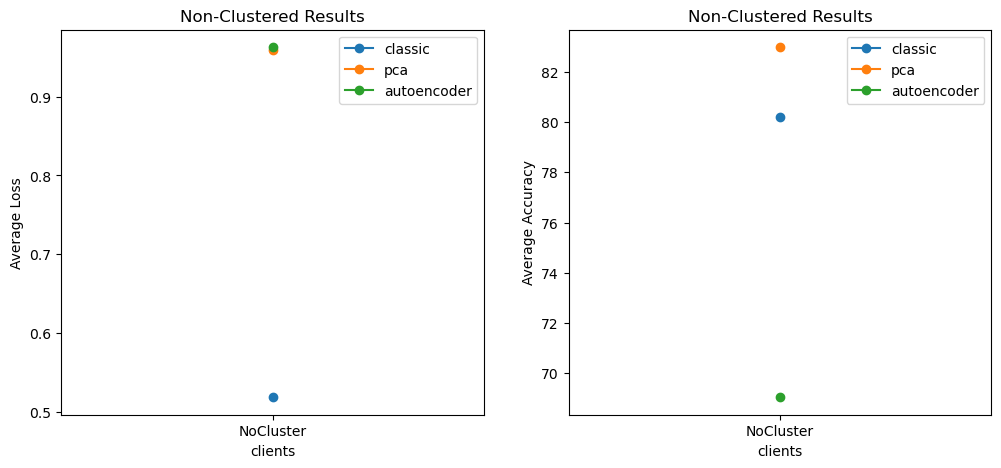


Clustered Results:
classic:
  Average Loss: {2: 0.5876620162963867, 4: 0.5333519813537598, 6: 0.4596880386352539, 8: 0.42250272445678716, 10: 0.4060860206604004}
  Average Accuracy: {2: 78.2825, 4: 80.175, 6: 82.86, 8: 84.545, 10: 85.215}
pca:
  Average Loss: {2: 0.9525542709350585, 4: 0.8761544845581055, 6: 0.8161749572753907, 8: 0.776599919128418, 10: 0.7339353118896486}
  Average Accuracy: {2: 80.01714285714286, 4: 80.34099999999998, 6: 81.31260869565217, 8: 82.31145161290323, 10: 83.06230769230767}
autoencoder:
  Average Loss: {2: 0.8455082565307617, 4: 0.8182457916259765, 6: 0.8660066467285156, 8: 0.9096631774902344, 10: 1.0132088317871095}
  Average Accuracy: {2: 75.81, 4: 77.375, 6: 76.78, 8: 76.15, 10: 74.52}


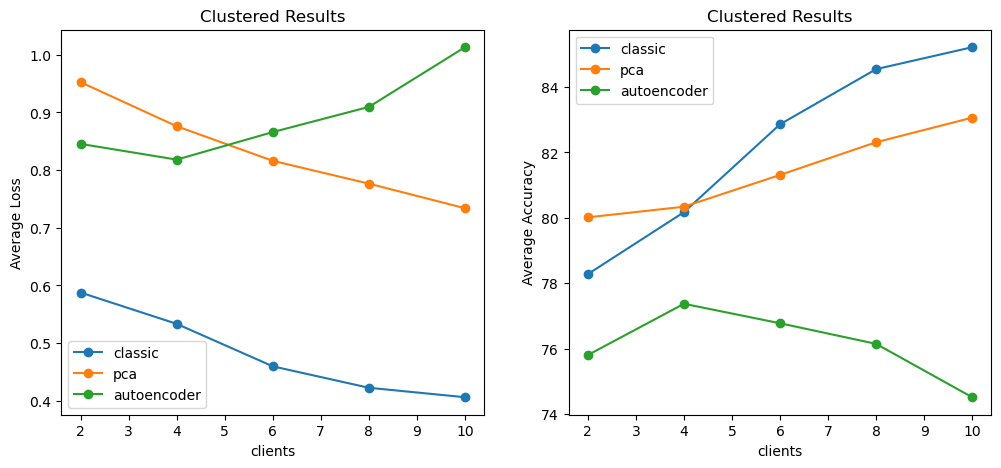

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#TODO: we have to multiply time by 8 first

# Function to compute final metrics
def compute_final_metrics(metrics):
    final_loss = {alpha: data['losses'][-1] for alpha, data in metrics.items()}
    final_accuracy = {alpha: data['accuracy'][-1] for alpha, data in metrics.items()}
    final_precision = {alpha: data['precision'][-1] for alpha, data in metrics.items()}
    final_f1 = {alpha: data['f1'][-1] for alpha, data in metrics.items()}
    final_recall = {alpha: data['recall'][-1] for alpha, data in metrics.items()}

    # Sum of all training times
    total_time = {
        alpha: sum(data.get('TrainingTime', data.get('trainingTime', [0])))
        for alpha, data in metrics.items()
    }

    return final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time

# Function to print results
def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])
        print(f"{method}:")
        print("  Final Loss:", final_loss)
        print("  Final Accuracy:", final_accuracy)
        print("  Final Precision:", final_precision)
        print("  Final F1 Score:", final_f1)
        print("  Final Recall:", final_recall)
        print("  Total Time:", total_time)

# Function to plot the results
def plot_results(results, title, filename):
    plt.figure(figsize=(15, 10))

    # List of metrics to plot
    metrics_names = ["Loss", "Accuracy", "Precision", "F1 Score", "Recall", "Total Time"]
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 3, i + 1)

        # Plotting each method's metrics
        for method in results.keys():
            final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])

            # Select the right metric based on the iteration
            metric_values = {
                "Loss": final_loss,
                "Accuracy": final_accuracy,
                "Precision": final_precision,
                "F1 Score": final_f1,
                "Recall": final_recall,
                "Total Time": total_time
            }[metric]

            # Plot the metric values for each method
            plt.plot(list(metric_values.keys()) + ['NoCluster'], list(metric_values.values()) + [metric_values.get('NoCluster', np.nan)], marker='o', label=method)

        plt.xlabel('Clusters')
        plt.ylabel(metric)
        plt.title(f'{title} - Clusters vs {metric}')
        plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Assuming 'results' and 'clusteredResults' are the data for the methods
# Print and plot results for non-clustered and clustered data

print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")

print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
